In [1]:
cd /home/jupyter/PACE

/home/jupyter/PACE


In [2]:
ls

Declarations_19722_Merge.cpg  Declarations_19722_Merge.shp.xml
Declarations_19722_Merge.dbf  Declarations_19722_Merge.shx
Declarations_19722_Merge.prj  aoi_flood_footprint.geojson
Declarations_19722_Merge.sbn  data/
Declarations_19722_Merge.sbx  notebooks/
Declarations_19722_Merge.shp


# **Install & import packages**

In [3]:
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods
!pip install pygeos

  Cloning https://github.com/spaceml-org/ml4floods to /tmp/pip-install-4dbl2a__/ml4floods_247333967b5142ba9db787d8bb02f940
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/ml4floods /tmp/pip-install-4dbl2a__/ml4floods_247333967b5142ba9db787d8bb02f940
  Resolved https://github.com/spaceml-org/ml4floods to commit 0f8fdc4b6b891ed249f52fda19ee23c50462e237
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pygeos
gpd.options.use_pygeos = True

# **Getting the buildings affected by the floods in the government supplied AOI.**

## Getting the intersection DF

In [5]:
# Returns a geodata with the buildings affected in the government supplied AOI.

def get_intersection(aoi_footprintPath: str, aoi_mapPath: str ):
    
    # Reading the files in.
    aoi_footprint = gpd.read_file(aoi_footprintPath)
    aoi_map = gpd.read_file(aoi_mapPath)

    # Finding the affected buildings in the government supplied AOI. 
    aoi_intersect = gpd.overlay(aoi_map, aoi_footprint, how='intersection')
    
    length = len(aoi_intersect.groupby('class').get_group('flood-trace'))
    
    # Number of affected buildings.
    print(f'There are {length} buildings affected in this AOI')
    
    # Saving the file. 
    aoi_intersect.to_file("data/aoi_intersect.geojson", driver='GeoJSON')
    
    return aoi_intersect

In [131]:
aoi_footprint_path = 'data/syd_reduced_footprint.geojson'
aoi_footprint = gpd.read_file(aoi_footprint_path)

aoi_map_path = 'data/syd_reduced_map.geojson'
aoi_map = gpd.read_file(aoi_map_path)

In [7]:
test = get_intersection(aoi_footprint_path, aoi_map_path)

There are 399 buildings affected in this AOI


`intersection()` with parameter `align = True` checks for the exact coordinates in both dataframes. Considering they won't match in coordinates, we won't find intersections. One dataframe has the coordinates for polygons of the floodmap and the other is coordinates for buildings. 

In [8]:
intersection = aoi_footprint['geometry'].intersection(aoi_map['geometry'], align= True)

/opt/conda/lib/python3.7/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.7/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Displaying everything BUT the empty and none polygons

In [9]:
intersection[(intersection.is_empty == False) & (intersection.isna() == False)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  """Entry point for launching an IPython kernel.


0    POLYGON ((150.80019 -32.32059, 150.80024 -32.3...
1    POLYGON ((150.81629 -32.30646, 150.81631 -32.3...
dtype: geometry

In [10]:
aoi_footprint['geometry']

0        POLYGON ((150.80033 -32.32067, 150.80037 -32.3...
1        POLYGON ((150.81640 -32.30648, 150.81642 -32.3...
2        POLYGON ((150.83105 -32.73790, 150.83114 -32.7...
3        POLYGON ((150.84422 -32.44826, 150.84432 -32.4...
4        POLYGON ((150.81490 -32.25455, 150.81503 -32.2...
                               ...                        
21045    POLYGON ((151.18303 -32.56620, 151.18304 -32.5...
21046    POLYGON ((151.17889 -32.54310, 151.17892 -32.5...
21047    POLYGON ((151.18157 -32.54495, 151.18167 -32.5...
21048    POLYGON ((151.18859 -32.56647, 151.18866 -32.5...
21049    POLYGON ((151.19544 -32.60997, 151.19548 -32.6...
Name: geometry, Length: 21050, dtype: geometry

In [11]:
test.groupby('class').get_group('flood-trace')['geometry']

295      POLYGON ((150.88725 -32.25680, 150.88736 -32.2...
436      POLYGON ((150.88356 -32.33784, 150.88359 -32.3...
449      POLYGON ((150.87831 -32.32271, 150.87819 -32.3...
1014     POLYGON ((150.99354 -32.54876, 150.99354 -32.5...
1095     POLYGON ((150.97138 -32.57291, 150.97134 -32.5...
                               ...                        
42445    POLYGON ((151.18287 -32.55453, 151.18285 -32.5...
42459    POLYGON ((151.11194 -32.68864, 151.11200 -32.6...
42488    POLYGON ((151.19435 -32.59770, 151.19441 -32.5...
42511    POLYGON ((151.16862 -32.43871, 151.16856 -32.4...
42608    POLYGON ((151.13915 -32.56989, 151.13922 -32.5...
Name: geometry, Length: 399, dtype: geometry

We want to retain the full footprint, so lets get the coordinates of the intersect and find what it looks like in the footprint DF. 

Could loop through each coordinate to see if the any of the vertices of the intersect match the footprint intersect then print the index location(s) of where they match in the footprint DF to get the full shape of the building. 

## Looping through each coordinate to find intersection coordinates in the Footprint dataframe

In [12]:
import numpy as np

Getting the flood-trace class

In [13]:
test.groupby('class').get_group('flood-trace')

,class,geometry
295,flood-trace,"POLYGON ((150.88725 -32.25680, 150.88736 -32.2..."
436,flood-trace,"POLYGON ((150.88356 -32.33784, 150.88359 -32.3..."
449,flood-trace,"POLYGON ((150.87831 -32.32271, 150.87819 -32.3..."
1014,flood-trace,"POLYGON ((150.99354 -32.54876, 150.99354 -32.5..."
1095,flood-trace,"POLYGON ((150.97138 -32.57291, 150.97134 -32.5..."
...,...,...
42445,flood-trace,"POLYGON ((151.18287 -32.55453, 151.18285 -32.5..."
42459,flood-trace,"POLYGON ((151.11194 -32.68864, 151.11200 -32.6..."
42488,flood-trace,"POLYGON ((151.19435 -32.59770, 151.19441 -32.5..."
42511,flood-trace,"POLYGON ((151.16862 -32.43871, 151.16856 -32.4..."


Checking the first index, being 295 and not 1. This is the case becaus the full `test` DF contains many classes, but we filtered by the flood-trace class in the previous cell.

In [14]:
test.loc[295]

class                                             flood-trace
geometry    POLYGON ((150.8872532897568 -32.25679598968163...
Name: 295, dtype: object

Details of the first polygon in the footprint dataframe (i.e. the coordinates of the first building in the DF)

Accessing the coordinates of the first building. 

In [15]:
test.groupby('class').get_group('flood-trace')['geometry'].index

Int64Index([  295,   436,   449,  1014,  1095,  1156,  1188,  1360,  1426,
             1552,
            ...
            41924, 41927, 42071, 42232, 42412, 42445, 42459, 42488, 42511,
            42608],
           dtype='int64', length=399)

In [16]:
test['geometry'][295].bounds

(150.8871978737571, -32.25693153405079, 150.8873607340969, -32.25679598968163)

In [17]:
aoi_footprint['geometry'][0].bounds

(150.8001922262388, -32.3206707407335, 150.8003744702567, -32.32053677553388)

In [18]:
test['geometry'][0].bounds

(150.8001922262388, -32.3206707407335, 150.8003744702567, -32.32053677553388)

In [19]:
test['geometry'][41927].bounds == test['geometry'][41927].bounds

True

In [20]:
test['geometry'][41927].bounds

(151.1512153715256, -32.58407969618406, 151.1513278599995, -32.58392574669479)

With the below loop, we should expect 399 'j' indices. 

In [58]:
footprintCoordinatesIndex = []
intersectCoordinatesIndex = []

for i in test.groupby('class').get_group('flood-trace')['geometry'].index:
    print(f'Checking Intersection index {i}')
    for j in range(len(aoi_footprint)):
        # print(f'Checking Footprint index {j}')
        if test['geometry'][i].bounds == aoi_footprint['geometry'][j].bounds:
            print(f'Footprint index {j} contains the full coordinates for Intersection index {i}')
            footprintCoordinatesIndex = np.append(footprintCoordinatesIndex, j)
            intersectCoordinatesIndex = np.append(intersectCoordinatesIndex, i)
            break
            


Checking Intersection index 295
Footprint index 146 contains the full coordinates for Intersection index 295
Checking Intersection index 436
Checking Intersection index 449
Checking Intersection index 1014
Checking Intersection index 1095
Checking Intersection index 1156
Checking Intersection index 1188
Footprint index 586 contains the full coordinates for Intersection index 1188
Checking Intersection index 1360
Checking Intersection index 1426
Checking Intersection index 1552
Checking Intersection index 1609
Footprint index 793 contains the full coordinates for Intersection index 1609
Checking Intersection index 1779
Checking Intersection index 1977
Footprint index 975 contains the full coordinates for Intersection index 1977
Checking Intersection index 2421
Checking Intersection index 2433
Checking Intersection index 2605
Footprint index 1286 contains the full coordinates for Intersection index 2605
Checking Intersection index 2676
Footprint index 1321 contains the full coordinates f

In [47]:
aoi_footprint['geometry'][9563].bounds == test['geometry'][19409].bounds

True

The Intersection index full coordinates found with the above loop are: 

In [59]:
footprintCoordinatesIndex

array([  146.,   586.,   793.,   975.,  1286.,  1321.,  1839.,  2006.,
        2019.,  2043.,  2049.,  2051.,  2083.,  2090.,  2167.,  2197.,
        2203.,  2210.,  2215.,  2315.,  2380.,  2505.,  2611.,  3342.,
        3402.,  3453.,  3488.,  3627.,  3721.,  3762.,  3796.,  3798.,
        3998.,  4018.,  4422.,  4629.,  4667.,  4717.,  4718.,  4828.,
        4829.,  4918.,  4986.,  5038.,  5061.,  5201.,  5234.,  5464.,
        5645.,  5664.,  5897.,  5922.,  5945.,  5969.,  6059.,  6092.,
        6271.,  6482.,  6625.,  6681.,  6848.,  6864.,  7200.,  7470.,
        7523.,  7536.,  7547.,  7561.,  7627.,  7686.,  7706.,  7737.,
        7746.,  7880.,  7885.,  7920.,  8042.,  8146.,  8548.,  8639.,
        8864.,  8888.,  8894.,  8895.,  8999.,  9049.,  9052.,  9203.,
        9260.,  9544.,  9563.,  9796., 10005., 10095., 10123., 10159.,
       10314., 10639., 10651., 10749., 10863., 11086., 11270., 11276.,
       11330., 11368., 11402., 11500., 11751., 11916., 11981., 12135.,
      

In [62]:
len(footprintCoordinatesIndex)

179

The remaining Intersection index to find their full coordinates are:

In [61]:
intersectCoordinatesIndex

array([  295.,  1188.,  1609.,  1977.,  2605.,  2676.,  3716.,  4055.,
        4082.,  4132.,  4145.,  4150.,  4219.,  4235.,  4394.,  4455.,
        4468.,  4483.,  4494.,  4695.,  4828.,  5082.,  5297.,  6765.,
        6887.,  6993.,  7068.,  7348.,  7541.,  7624.,  7693.,  7698.,
        8104.,  8145.,  8965.,  9383.,  9462.,  9565.,  9568.,  9796.,
        9799.,  9980., 10117., 10222., 10269., 10554., 10622., 11084.,
       11451., 11490., 11962., 12013., 12060., 12109., 12290., 12357.,
       12725., 13154., 13442., 13555., 13891., 13924., 14598., 15146.,
       15255., 15282., 15308., 15338., 15472., 15592., 15634., 15697.,
       15716., 15987., 15999., 16070., 16319., 16531., 17340., 17525.,
       17981., 18031., 18046., 18049., 18261., 18364., 18371., 18677.,
       18794., 19370., 19409., 19883., 20305., 20490., 20548., 20624.,
       20942., 21595., 21620., 21820., 22049., 22496., 22873., 22887.,
       22997., 23075., 23145., 23345., 23852., 24185., 24319., 24631.,
      

In [67]:
len(intersectCoordinatesIndex)

179

Number of Intersection indices to find:

In [68]:
len(test.groupby('class').get_group('flood-trace')['geometry'].index) - len(intersectCoordinatesIndex)

220

In [69]:
if intersectCoordinatesIndex == test.groupby('class').get_group('flood-trace')['geometry'].index
    print('test')

SyntaxError: invalid syntax (3141373569.py, line 1)

In [72]:
test.groupby('class').get_group('flood-trace')['geometry'].index[0]

295

In [83]:
remainingIndex = []
for i in range(len(intersectCoordinatesIndex)):
    # print(i)
    if intersectCoordinatesIndex[i] != test.groupby('class').get_group('flood-trace')['geometry'].index[i]:
        remainingIndex = np.append(remainingIndex, test.groupby('class').get_group('flood-trace')['geometry'].index[i])
    else:
        print(i)

0


In [84]:
len(remainingIndex)

178

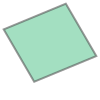

In [90]:
test.groupby('class').get_group('flood-trace')['geometry'][42412]

In [99]:
aoi_footprint['geometry']

0        POLYGON ((150.80033 -32.32067, 150.80037 -32.3...
1        POLYGON ((150.81640 -32.30648, 150.81642 -32.3...
2        POLYGON ((150.83105 -32.73790, 150.83114 -32.7...
3        POLYGON ((150.84422 -32.44826, 150.84432 -32.4...
4        POLYGON ((150.81490 -32.25455, 150.81503 -32.2...
                               ...                        
21045    POLYGON ((151.18303 -32.56620, 151.18304 -32.5...
21046    POLYGON ((151.17889 -32.54310, 151.17892 -32.5...
21047    POLYGON ((151.18157 -32.54495, 151.18167 -32.5...
21048    POLYGON ((151.18859 -32.56647, 151.18866 -32.5...
21049    POLYGON ((151.19544 -32.60997, 151.19548 -32.6...
Name: geometry, Length: 21050, dtype: geometry

In [ ]:
type(aoi_map)

geopandas.geodataframe.GeoDataFrame

# end of notebook

In [107]:
test1 = gpd.overlay(aoi_map.groupby('class').get_group('flood-trace'), aoi_footprint, how='intersection')
test2 = gpd.overlay(aoi_footprint, aoi_map.groupby('class').get_group('flood-trace'), how='intersection')



In [132]:
aoi_map= aoi_map.groupby('class').get_group('flood-trace')

In [133]:
aoi_map['index'] = aoi_map.index

In [134]:
aoi_map

,class,geometry,index
125,flood-trace,"POLYGON ((150.77920 -32.45335, 150.77920 -32.4...",125
126,flood-trace,"POLYGON ((150.81227 -32.59426, 150.81165 -32.5...",126
127,flood-trace,"POLYGON ((150.80230 -32.59264, 150.80124 -32.5...",127
128,flood-trace,"POLYGON ((150.81061 -32.57484, 150.81062 -32.5...",128
129,flood-trace,"POLYGON ((150.80853 -32.57282, 150.80907 -32.5...",129
...,...,...,...
2054,flood-trace,"POLYGON ((151.19993 -32.40857, 151.19972 -32.4...",2054
2055,flood-trace,"POLYGON ((151.18702 -32.36843, 151.18733 -32.3...",2055
2056,flood-trace,"POLYGON ((151.18673 -32.36690, 151.18725 -32.3...",2056
2057,flood-trace,"POLYGON ((151.18791 -32.36114, 151.18790 -32.3...",2057


In [135]:
aoi_footprint['footprint_index'] = aoi_footprint.index

In [176]:
test3 = gpd.overlay(aoi_map, aoi_footprint, how='intersection')


In [177]:
test3

,class,index,footprint_index,geometry
0,flood-trace,137,14713,"POLYGON ((150.80711 -32.48319, 150.80714 -32.4..."
1,flood-trace,157,20010,"POLYGON ((150.80891 -32.29164, 150.80892 -32.2..."
2,flood-trace,159,14697,"POLYGON ((150.80607 -32.29101, 150.80606 -32.2..."
3,flood-trace,160,10710,"POLYGON ((150.80794 -32.28899, 150.80792 -32.2..."
4,flood-trace,160,14729,"POLYGON ((150.80761 -32.28906, 150.80765 -32.2..."
...,...,...,...,...
394,flood-trace,2044,14056,"POLYGON ((151.18242 -32.54678, 151.18262 -32.5..."
395,flood-trace,2044,15836,"POLYGON ((151.18173 -32.54645, 151.18195 -32.5..."
396,flood-trace,2044,18137,"POLYGON ((151.18197 -32.54672, 151.18190 -32.5..."
397,flood-trace,2044,19351,"POLYGON ((151.18262 -32.54686, 151.18270 -32.5..."


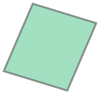

In [142]:
aoi_footprint['geometry'][14713]

In [154]:
aoi_footprint['geometry'][test3['footprint_index'].index]

0      POLYGON ((150.80033 -32.32067, 150.80037 -32.3...
1      POLYGON ((150.81640 -32.30648, 150.81642 -32.3...
2      POLYGON ((150.83105 -32.73790, 150.83114 -32.7...
3      POLYGON ((150.84422 -32.44826, 150.84432 -32.4...
4      POLYGON ((150.81490 -32.25455, 150.81503 -32.2...
                             ...                        
394    POLYGON ((150.89824 -32.25064, 150.89836 -32.2...
395    POLYGON ((150.90542 -32.28570, 150.90539 -32.2...
396    POLYGON ((150.90204 -32.28617, 150.90212 -32.2...
397    POLYGON ((150.89696 -32.25255, 150.89712 -32.2...
398    POLYGON ((150.90060 -32.28568, 150.90067 -32.2...
Name: geometry, Length: 399, dtype: geometry

In [164]:
test3['footprint_index']

0      14713
1      20010
2      14697
3      10710
4      14729
       ...  
394    14056
395    15836
396    18137
397    19351
398    19932
Name: footprint_index, Length: 399, dtype: int64

In [189]:
for i, val in enumerate(test3['footprint_index']):
    # print(i)
    test3['full_geometry'][i] = aoi_footprint['geometry'][val]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


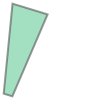

In [190]:
test3['geometry'][0]

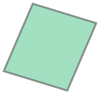

In [192]:
test3['full_geometry'][0]

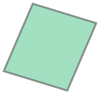

In [193]:
aoi_footprint['geometry'][14713]

In [ ]:
test3 = test3.drop(columns= 'geometry')

In [200]:
test3['geometry'] = test3['full_geometry']
test3 = test3.drop(columns = 'full_geometry')

In [201]:
test3.to_file("data/aoi_intersect.geojson", driver='GeoJSON')